**0. Data Cleaning**

In [2]:
# load and clean data
import pandas as pd
train_all = pd.read_csv("/root/data/train.csv")
test = pd.read_csv("/root/data/test.csv")

# remove dates on or after March 12 from training set
train_all = train_all.set_index('Date')
train = train_all.loc[train_all.index < '2020-03-12'] 
public_test = train_all.loc[train_all.index >= '2020-03-12'] 

# sort train and public test sets
train = train.sort_values(by = 'Date')
public_test = public_test.sort_values(by = 'Date')

# fill 'NaN' Province/State values with Country/Region values
train['Province/State'] = train['Province/State'].fillna(train['Country/Region'])
public_test['Province/State'] = public_test['Province/State'].fillna(public_test['Country/Region'])

**1. Data exploration**

TODO
1. Tsne/Umap visualization of states/countries clustered by healthcare system variates or by population variates?

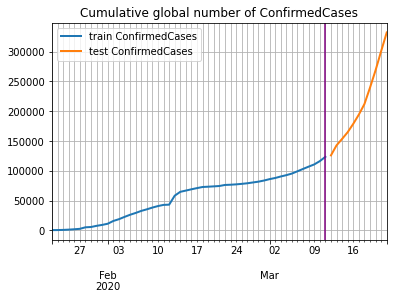

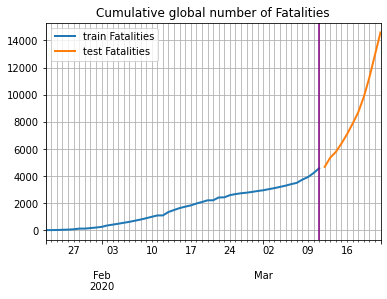

In [40]:
# plot confirmed cases and fatalities in train an
import matplotlib.pyplot as plt
cum_train = train.groupby('Date').sum()
cum_test = public_test.groupby('Date').sum()

def plot_observations(
    target: str = 'ConfirmedCases'
):
    train_ds = ListDataset(
        [{"start": cum_train.index[0], "target": cum_train[target].values}],
        freq = "D",
    )
    test_ds = ListDataset(
        [{"start": cum_test.index[0], "target": cum_test[target].values}],
        freq = "D",
    )
    
    for tr, te in zip(train_ds, test_ds):
        to_pandas(tr).plot(linewidth=2, label = f'train {target}')
        to_pandas(te).plot(linewidth=2, label = f'test {target}')   
    
    plt.axvline(cum_train.index[-1], color='purple') # end of train dataset
    plt.title(f'Cumulative global number of {target}')
    plt.legend()
    plt.grid(which="both")
    plt.show()
    
plot_observations('ConfirmedCases')
plot_observations('Fatalities')

**2. Data Augmentation**

TODO:
1. Add covariates (country healthcare system, country population statistics)

In [7]:
from gluonts.dataset.common import ListDataset

def build_train_data(target: str = 'Fatalities'):
    return ListDataset(
        [
            {"start": df.index[0], "target": df[target].values} # df[['ConfirmedCases', 'Fatalities']].values
            for g, df in train.groupby(by='Province/State')
        ],
        freq = "D",
        #one_dim_target = False
    )
training_data = build_train_data()

**3. Fit DeepAR Model Estimates**

The DeepAR model is estimating the alpha and mu parameters of a negative binomial distribution (time variant).

TODO:
1. Discuss DeepAR modeling approach - what are its assumptions, limitations.
2. Parameterize multivariate distribution with both 'ConfirmedCases' and 'Fatalities' as targets?
3. Add Box Cox transformation before learning NegBin paramaters?

In [48]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.distribution import NegativeBinomialOutput
import mxnet as mx

# set random seed for reproducibility
mx.random.seed(42)

estimator = DeepAREstimator(
    freq="D", 
    prediction_length=11, 
    distr_output=NegativeBinomialOutput(),
    trainer=Trainer(epochs=20, learning_rate=0.01, batch_size=64)
)
predictor = estimator.train(training_data=training_data)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.01
100%|██████████| 50/50 [00:02<00:00, 17.40it/s, avg_epoch_loss=0.333]
INFO:root:Epoch[0] Elapsed time 2.881 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.332937
INFO:root:Epoch[1] Learning rate is 0.01
100%|██████████| 50/50 [00:02<00:00, 18.00it/s, avg_epoch_loss=0.185]
INFO:root:Epoch[1] Elapsed time 2.784 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.184918
INFO:root:Epoch[2] Learning rate is 0.01
100%|██████████| 50/50 [00:02<00:00, 18.47it/s, avg_epoch_loss=0.158]
INFO:root:Epoch[2] Elapsed time 2.708 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.158020
INFO:root:Epoch[3] Learning rate is 0.01
100%|██████████| 50/50 [00:02<00:00, 18.07it/s, avg_epoch_loss=0.132]
INFO:root:Epoch[3] Elapsed time 2.772 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.131593
INFO:root:Epoch[4] Learning rate is 0.01
100%|██████████| 50/50 [00:02<00:00, 18.33it

**4. Make and plot predictions from fit model params**

**Visualize Fatality Forecasts**

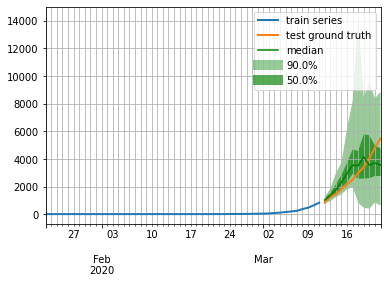

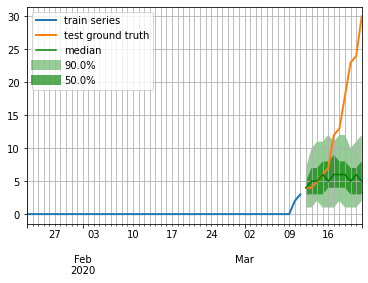

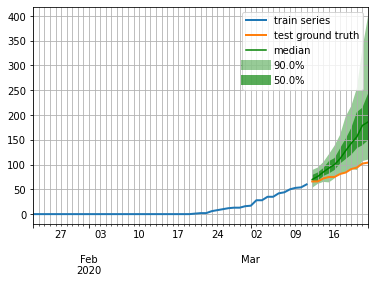

In [49]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

def plot_forecast(
    location: str = 'Italy',
    target: str = 'Fatalities'
):
    
    # plot train observations, true observations from public test set, and forecasts
    train_df = train[train['Province/State'] == location]
    train_obs = ListDataset(
        [{"start": train_df.index[0], "target": train_df[target].values}],
        freq = "D",
    )
    gt_df = public_test[public_test['Province/State'] == location]
    test_gt = ListDataset(
        [{"start": gt_df.index[0], "target": gt_df[target].values}],
        freq = "D",
    )
    for train_series, gt, forecast in zip(train_obs, test_gt, predictor.predict(train_obs)):
        to_pandas(train_series).plot(linewidth=2, label = 'train series')
        to_pandas(gt).plot(linewidth=2, label = 'test ground truth')
        forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
    
    plt.legend()
    plt.grid(which='both')
    plt.show()
    
plot_forecast('Italy')
plot_forecast('California')
plot_forecast('Korea, South')


**5. Interrogate importance of covariates (how - maybe model-agnostic method like SHAP values?)

**6. Calculate metrics on public test